In [1]:
!pip install -q -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
!pip install tqdm

In [3]:
import nltk
import evaluate
import numpy as np
from datasets import load_dataset
import os,torch
from huggingface_hub import HfFolder, login

In [7]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, DebertaV2Model, DebertaV2Tokenizer, AdamW
from transformers import  AutoConfig, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn


In [4]:
ds = load_dataset("tarekziade/profanity-clean")

README.md:   0%|          | 0.00/337 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/91222 [00:00<?, ? examples/s]

In [ ]:
ds['train'].features

In [24]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience # the number of epochs to wait for improvement before stopping, default=3
        self.min_delta = min_delta # the minimum change in validation loss that is considered an improvement, default is 0
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state_dict = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_state_dict = model.state_dict().copy()
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state_dict = model.state_dict().copy()


class CustomDebertaClassifier(nn.Module):
    def __init__(self, model_name='microsoft/deberta-v3-small', num_labels=2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.hidden_dropout_prob = 0.3
        self.config.attention_probs_dropout_prob = 0.2

        #self.deberta = AutoModelForSequenceClassification.from_pretrained(
        self.deberta = AutoModel.from_pretrained(
            model_name,
            config=self.config
        )

        # Add custom classification head
        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(self.config.hidden_size, 512)
        self.activation = nn.GELU()
        self.layer_norm = nn.LayerNorm(512)
        self.dropout2 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(512, num_labels)

    #def forward(self, **inputs):
        #outputs = self.deberta(**inputs)
    def forward(self, input_ids, attention_mask, labels=None, class_weights=None):
        #outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Use the CLS token representation for classification
        pooled_output = outputs[:, 0, :]
        #pooled_output = outputs.logits

        x = self.dropout1(pooled_output)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.layer_norm(x)
        x = self.dropout2(x)
        logits = self.linear2(x)

        loss = None
        if labels is not None:  # Calculate loss during training
            if class_weights is not None:
                loss_fct = nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss
            else:
                loss_fct = nn.CrossEntropyLoss()  # Standard cross-entropy loss
            loss = loss_fct(logits, labels)

        return logits, loss


# Model specific config

In [27]:
class PFDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_mapping = {i: text for i, text in enumerate(texts)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True, # special tokens like [CLS] (start of sequence) and [SEP] (end of sequence) that Roberta expects.
            max_length=self.max_length,
            padding='max_length', # pads shorter sequences with a special token ([PAD]) to make them all the same length.
            truncation=True, # sequence is longer than max_length, it gets truncated
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
            'idx': idx
        }

def create_data_splits(texts, labels, tokenizer, test_size=0.20, val_size=0.25, random_state=42):
    """
    Create train, validation, and test splits of the dataset
    """
    # First split: separate test set
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        texts,
        labels,
        test_size=test_size,
        random_state=random_state,
        stratify=labels  # Maintains class distribution
    )

    # Second split: separate train and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_val_texts,
        train_val_labels,
        #test_size=val_size/(1-test_size),  # Adjusted validation size
        test_size=val_size,
        random_state=random_state,
        stratify=train_val_labels  # Maintains class distribution
    )

    # Create datasets
    train_dataset = PFDataset(train_texts, train_labels, tokenizer)
    val_dataset = PFDataset(val_texts, val_labels, tokenizer)
    test_dataset = PFDataset(test_texts, test_labels, tokenizer)

    return train_dataset, val_dataset, test_dataset

def calculate_class_weights(labels):
  """Calculate class weights for imbalanced dataset"""
  class_counts = np.bincount(labels)
  total_samples = len(labels)
  weights = total_samples / (len(class_counts) * class_counts)
  return torch.FloatTensor(weights)

In [29]:
from evalmetrics import plot_metrics

def evaluate_model(model, data_loader, device, class_weights=None, criterion=None):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_indices = []

    with torch.no_grad(): # disables gradient calculations as only evaluation is being done and NOT training.
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['idx']

            logits, _ = model(input_ids, attention_mask)
            #outputs = model(input_ids, attention_mask)
            if criterion is not None:
                loss = criterion(logits, labels)
                #loss = criterion(outputs, labels)
                total_loss += loss.item()

            probs = torch.softmax(logits, dim=1) # logits converted to probablities using the softmax function
            #probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(logits, dim=1) #predicted class determined by selecting the class with the highest probablity
            #preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_indices.extend(indices.numpy())

    metrics = {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'indices': all_indices,
        'recall': recall_score(all_labels, all_preds),
        'loss': total_loss / len(data_loader) if criterion is not None else None
    }

    return metrics

def train_model(config,model,train_loader, val_loader, test_loader, num_epochs=10,patiencestep=3,lrate=2e-5,weight_decay=0.01,factorrate=0.1,max_norm=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = config['class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=lrate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=factorrate, patience=patiencestep, verbose=True
    )  # learning rate scheduler that reduces the learning rate when the validation metric (recall) plateaus. This helps to fine-tune the model and prevent overfitting.

    # early stopping and metrics initialization
    best_val_recall = 0
    patience = patiencestep
    patience_counter = 0

    early_stopping = EarlyStopping(patience=patiencestep)

    train_losses = []
    val_losses = []
    val_recalls = []
    all_labels = []  # Initialize all_labels here
    all_probs = []  # Initialize all_probs here

    for epoch in range(config['epochs']):
        print(f'\nEpoch {epoch + 1}/{config["epochs"]}')

        # Training Mode
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs, _ = model(input_ids, attention_mask, labels-labels)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()
            #scheduler.step()

            total_train_loss += loss.item()
            #progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Mode
        val_metrics = evaluate_model(
            model,
            val_loader,
            device,
            class_weights,
            criterion
        )
        val_losses.append(val_metrics['loss'])
        val_recalls.append(val_metrics['recall'])

        # Assign val_preds from the validation metrics returned in val_metrics
        val_preds = val_metrics['predictions']
        val_labels = val_metrics['labels'] # Get validation labels from val_metrics

        all_labels.extend(val_metrics['labels'])  # Extend with validation labels
        all_probs.extend(val_metrics['probabilities'])
        #all_probs.extend(val_preds)  # Extend with validation predictions (probs)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_metrics["loss"]:.4f}')
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_preds))
        #print(f'Val Recall: {val_metrics["recall"]:.4f}')

        scheduler.step(val_metrics['recall'])

        if val_metrics['recall'] > best_val_recall:
            best_val_recall = val_metrics['recall']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Final evaluation on test set
    test_metrics = evaluate_model(
        model,
        test_loader,
        device,
        class_weights,
        criterion  # Add criterion for evaluate_model
    )

    print('\nTest Set Results:')
    print(f'Test Loss: {test_metrics["loss"]:.4f}')
    print('\nTest Classification Report:')
    print(classification_report(test_metrics['labels'], test_metrics['predictions']))

    #plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, val_recalls, test_metrics)

    # Plot confusion matrix
    plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, test_metrics)

    #return model
    return train_losses, val_losses, val_recalls, model

In [39]:
config = {
    'model_name': 'microsoft/deberta-v3-small',
    'max_length': 128,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout_rate': 0.2,
    'hidden_dropout_rate': 0.3,
    'outputmdlpath' : '/content/finetunedmdl',

}

In [40]:
#Calculate class weights

ds_df = ds['train'].to_pandas()
class_weights = calculate_class_weights(ds_df['is_offensive'].values)
config['class_weights'] = class_weights
print("\nClass Weights:")
print(class_weights)


# Calculate class distribution
class_distribution = ds_df['is_offensive'].value_counts()
print("\nClass Distribution:")
print(class_distribution)
print("\nClass Distribution (%):")
print(class_distribution / len(ds_df) * 100)


Class Weights:
tensor([0.7452, 1.5195])

Class Distribution:
is_offensive
0    61205
1    30017
Name: count, dtype: int64

Class Distribution (%):
is_offensive
0    67.094561
1    32.905439
Name: count, dtype: float64


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
#model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)
# Initialize CustomDeberta
model = CustomDebertaClassifier().to(device)


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training set size: 54732
Validation set size: 18245
Test set size: 18245

Epoch 1/10


Epoch 1/10: 100%|██████████| 3421/3421 [07:16<00:00,  7.84it/s]


Epoch 1:
Training Loss: 0.2095
Validation Loss: 0.1766

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     12242
           1       0.92      0.96      0.94      6003

    accuracy                           0.96     18245
   macro avg       0.95      0.96      0.95     18245
weighted avg       0.96      0.96      0.96     18245


Epoch 2/10


Epoch 2/10: 100%|██████████| 3421/3421 [07:16<00:00,  7.85it/s]


Epoch 2:
Training Loss: 0.1452
Validation Loss: 0.1461

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     12242
           1       0.87      0.98      0.92      6003

    accuracy                           0.94     18245
   macro avg       0.93      0.95      0.94     18245
weighted avg       0.95      0.94      0.94     18245


Epoch 3/10


Epoch 3/10: 100%|██████████| 3421/3421 [07:16<00:00,  7.85it/s]


Epoch 3:
Training Loss: 0.1283
Validation Loss: 0.1446

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     12242
           1       0.89      0.97      0.93      6003

    accuracy                           0.95     18245
   macro avg       0.94      0.96      0.95     18245
weighted avg       0.95      0.95      0.95     18245


Epoch 4/10


Epoch 4/10: 100%|██████████| 3421/3421 [07:16<00:00,  7.84it/s]


Epoch 4:
Training Loss: 0.1107
Validation Loss: 0.1945

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     12242
           1       0.89      0.97      0.93      6003

    accuracy                           0.95     18245
   macro avg       0.94      0.96      0.95     18245
weighted avg       0.95      0.95      0.95     18245


Epoch 5/10


Epoch 5/10: 100%|██████████| 3421/3421 [07:16<00:00,  7.84it/s]


Epoch 5:
Training Loss: 0.1009
Validation Loss: 0.1637

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     12242
           1       0.94      0.95      0.95      6003

    accuracy                           0.96     18245
   macro avg       0.96      0.96      0.96     18245
weighted avg       0.96      0.96      0.96     18245

Early stopping triggered!

Test Set Results:
Test Loss: 0.1661

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     12241
           1       0.93      0.95      0.94      6004

    accuracy                           0.96     18245
   macro avg       0.95      0.96      0.96     18245
weighted avg       0.96      0.96      0.96     18245



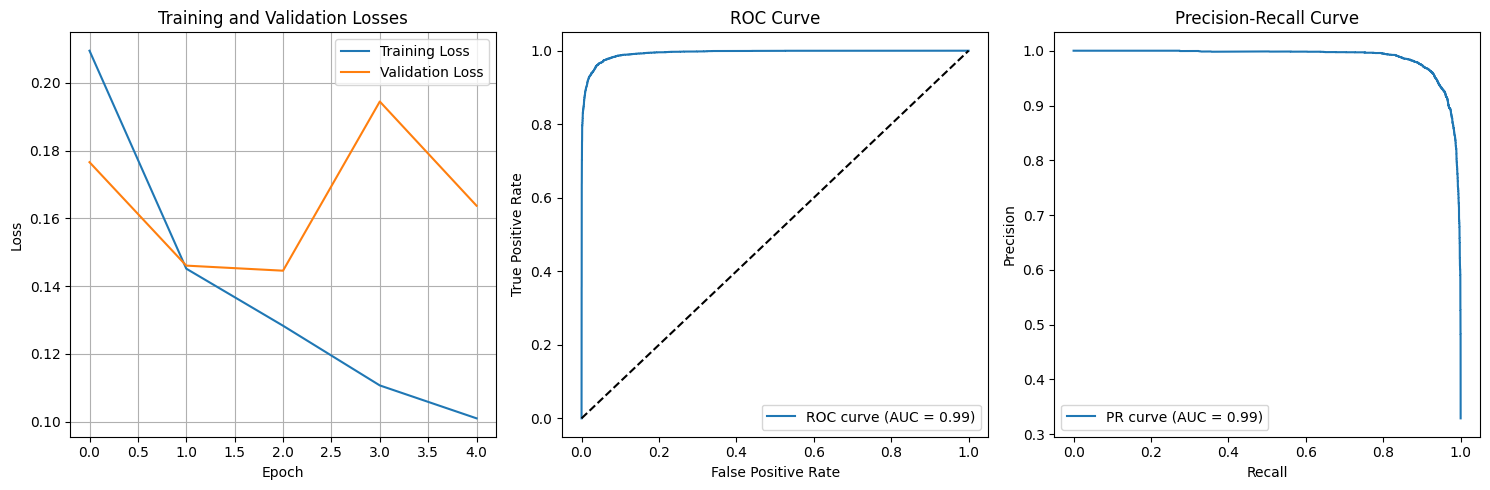

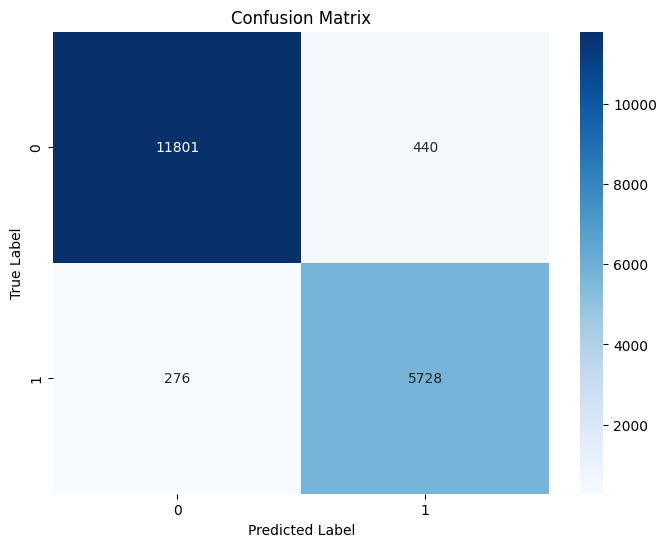

In [42]:


train_dataset, val_dataset, test_dataset = create_data_splits(
        texts=ds['train']['text'],
        labels=ds['train']['is_offensive'],
        tokenizer=tokenizer,
        test_size=0.20,
        val_size=0.25
    )


print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16
)


# train model
train_losses, val_losses, val_recalls, _ = train_model(
     config, model, train_loader, val_loader, test_loader
  )

# Load best model and evaluate by loading model weights onto the correct device
state_dict = torch.load('best_model.pt', map_location=device, weights_only=True)

# Load  weights and other necessary state information into the model
model.load_state_dict(state_dict)

test_metrics = evaluate_model(model, test_loader, device)

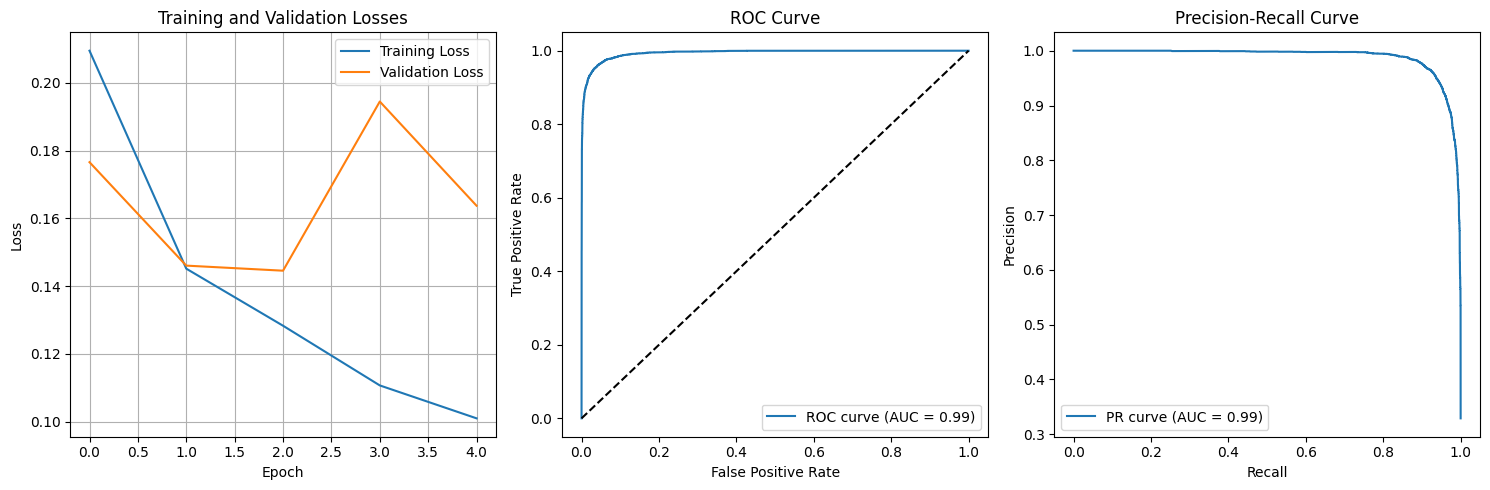

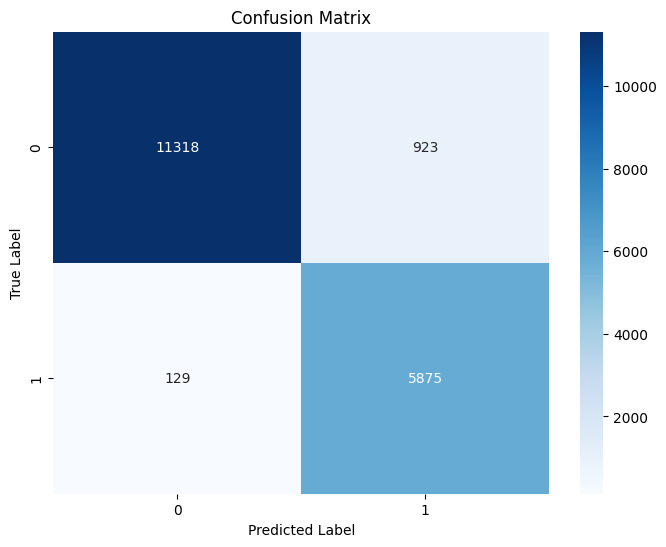

In [43]:
plot_metrics(train_losses, val_losses, test_metrics['labels'], test_metrics['probabilities'], val_recalls, test_metrics)


In [67]:
from evalmetrics import get_confusion_matrix_explanation, analyze_errors, display_error_analysis
get_confusion_matrix_explanation(test_metrics)


=== Confusion Matrix Explanation ===


{'TN_CM_Explanation': 'True Negatives (Non-PF correctly classified as Non-PF): 11318',
 'FP_CM_Explanation': 'False Positives (Non-PF incorrectly classified as PF): 923',
 'FN_CM_Explanation': 'False Negatives (PF incorrectly classified as Non-PF): 129',
 'TP_CM_Explanation': 'True Positives (PF correctly classified as PF): 5875',
 'Accuracy': '0.942',
 'Recall': 'Recall True Positive Rate): 0.979',
 'Precision': '0.864'}

In [68]:
  # Analyze errors
  org_dataset = PFDataset(texts=ds['train']['text'],
                          labels=ds['train']['is_offensive'],
                          tokenizer=tokenizer)
  false_positives, false_negatives = analyze_errors(test_metrics, test_dataset=org_dataset)

In [69]:
display_error_analysis(false_positives, false_negatives)


=== False Positives ({nl} classified as {lp}) ===

1. Index: 10325
Text: On top of that she just a pregnant ass sorry hoe Aint never got no money Even her water broke TallTrappin RIPTALLT
Confidence: 1.000

2. Index: 9005
Text: I know I luv her She rox my sox April
Confidence: 1.000

3. Index: 6163
Text: Test ping Test
Confidence: 1.000

4. Index: 13506
Text: Where s the pic of her standing again ArlisDoNotChill This bitch looks like Voltorb
Confidence: 1.000

5. Index: 10783
Text: Warning Talk
Confidence: 1.000

=== False Negatives ({lp} classified as {nl}) ===

1. Index: 17038
Text: Bush edit EXCUSE ME MISTER I DID NOT MAKE AN UNCONSTRUCTIVE EDIT TO BUSH I ADDED THE TERM FOR A REAL RACE OF PEOPLE LIVING IN AFRICA LOOK UP BUSHMEN

2. Index: 12304
Text: EmpressTaTa aww man we had a BALL Small lil affair Set that bitch out

3. Index: 5886
Text: Wikipedia HighBeam Applications is where you d find that in case you want to go asking I d recommend it it s proven really useful to me so far 

{'Total_FP_Count': 'Total False Positives: 923',
 'Total_FN_Count': 'Total False Negatives: 129'}

In [71]:
torch.save(model.state_dict(), os.path.join(config['outputmdlpath'], 'pytorch_model.bin'))
tokenizer.save_pretrained(config['outputmdlpath'])

('/content/finetunedmdl/tokenizer_config.json',
 '/content/finetunedmdl/special_tokens_map.json',
 '/content/finetunedmdl/spm.model',
 '/content/finetunedmdl/added_tokens.json',
 '/content/finetunedmdl/tokenizer.json')

In [115]:
import warnings
warnings.filterwarnings("ignore")
def infer_debertasentencevalidator(contextstr, mdlpath='/content/finetunedmdl'):
    try:
        ft_model = CustomDebertaClassifier()
        binpath = mdlpath + '/pytorch_model.bin'
        if os.path.exists(binpath):
            ft_model.load_state_dict(torch.load(binpath))
            ft_model.eval()
            tokenizer = AutoTokenizer.from_pretrained('/content/finetunedmdl/')
            result = {}

            result['contextstr'] = contextstr
            with torch.no_grad():
                #Tokenize inputs
                inputs = tokenizer(contextstr, return_tensors="pt")
                output = ft_model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                # get the outputtensor
                evallabel = output[0].argmax().item()
                result['evallabel'] = evallabel
                if evallabel==1:
                  result['prediction'] = 'offensive'
                else:
                  result['prediction'] = 'non-offensive'
            return result

    except Exception as e:
        return (f"Encountered error while performing inference: {e}")

In [116]:
infer_debertasentencevalidator(contextstr="you worst fellow")

{'contextstr': 'you worst fellow', 'evallabel': 1, 'prediction': 'offensive'}

In [133]:
testlist=["You worst idiot","You are asshole","You bloody nasty fellow",
          "You are pretty", "Its a bright morning", "its been a great pleasure talking to you",
          "You shut up and don't change my contributions!!!!", "shit-faced loser screw you",
          "I hate to talk to you", "you're blanking my comments you idiot you will pay for this",
          "He is a devil", "Exactly. Problem solved you moron", "You sounded like a fag the last three days",
          "Cursed how much everything happens on earth", "Few people do not have good hygiene",
          "You all should be locked or deserted alone"
          ]

In [134]:
resultdict = {'contextstr': [], 'evallabel': [], 'predictionresult': []}

for s in testlist:
    t = infer_debertasentencevalidator(contextstr=s)
    resultdict['contextstr'].append(s)
    resultdict['evallabel'].append(t['evallabel'])
    resultdict['predictionresult'].append(t['prediction'])
resultdf = pd.DataFrame(resultdict)

In [135]:
resultdf

,contextstr,evallabel,predictionresult
0,You worst idiot,1,offensive
1,You are asshole,1,offensive
2,You bloody nasty fellow,1,offensive
3,You are pretty,0,non-offensive
4,Its a bright morning,0,non-offensive
5,its been a great pleasure talking to you,0,non-offensive
6,You shut up and don't change my contributions!!!!,1,offensive
7,shit-faced loser screw you,1,offensive
8,I hate to talk to you,0,non-offensive
9,you're blanking my comments you idiot you will...,1,offensive
